In [1]:
import numpy 
import pandas
import cobra
import scipy, scipy.signal
from pathlib import Path
from cobra.io import load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model, load_model, to_json
import logging
import time 
import os
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(20, 10), 
                            'axes.labelsize':40})

import seaborn
import pingouin 
import scipy, scipy.stats
from scipy.stats import ttest_ind
import statsmodels, statsmodels.stats, statsmodels.stats.multitest
import cobamp
import docplex
import gseapy
import peat
import bioservices
import keggtools
from bioservices import KEGG
from keggtools import Resolver
import gseapy
import escher
import scipy.io
import json
from escher import Builder, rc
import scanpy
from IPython.display import display, Markdown

data_dir = Path(".") / ".." / "src" / "cobra" / "data"
data_dir = data_dir.resolve()

In [2]:
directory = "/Users/jaydee/Desktop/Thesis Project/For Python/Final_Models"
os.chdir(directory)

filenames = ['Laminar_90_optgp_k1000_n1000.csv', 'Oscillatory_90_optgp_k1000_n1000.csv', 'Static_90_optgp_k1000_n1000.csv']

patients = {}

for filename in filenames:
    key = filename.split('_')[0]
    df = pandas.read_csv(filename, index_col=0)
    patients[key] = df
    

flux_ids = pandas.read_csv('/Users/jaydee/Desktop/Thesis Project/For Python/Final_Models/Recon3D_rxns.csv', header = None )
flux_ids[0] = flux_ids[0].str.strip("'")
flux_ids.set_index(flux_ids.columns[0], inplace = True)
flux_ids.rename_axis('Flux IDs', axis='index', inplace=True)


common_flux = []

for key in patients.keys():
    df = patients[key]
    if len(common_flux) == 0:
        common_flux = set(df.index).intersection(flux_ids.index)
    else:
        common_flux = common_flux.intersection(set(df.index))

common_flux_df = pandas.DataFrame(list(common_flux), columns=['Flux IDs'])

for key in patients.keys():
    df = patients[key]
    df = df.loc[df.index.isin(common_flux)]
    patients[key] = df
    
not_common_flux = set(flux_ids.index) - set(common_flux)
not_common_flux_df = pandas.DataFrame(list(not_common_flux), columns=['Flux IDs'])


In [3]:
rxns_subSystem = pandas.read_csv('/Users/jaydee/Desktop/Thesis Project/For Python/Models/Samples/rxns_subsystems.csv')
rxns_subSystem

,rxns,subSystems
0,10FTHF5GLUtl,"Transport, lysosomal"
1,10FTHF5GLUtm,"Transport, mitochondrial"
2,10FTHF6GLUtl,"Transport, lysosomal"
3,10FTHF6GLUtm,"Transport, mitochondrial"
4,10FTHF7GLUtl,"Transport, lysosomal"
...,...,...
10595,CYOR_u10mi,Oxidative phosphorylation
10596,Htmi,"Transport, mitochondrial"
10597,NADH2_u10mi,Oxidative phosphorylation
10598,CYOOm3i,Oxidative phosphorylation


In [4]:
merged_df = pandas.merge(common_flux_df, rxns_subSystem, left_on = 'Flux IDs', right_on = 'rxns', how = 'left')
merged_df = merged_df[['Flux IDs', 'subSystems']]
merged_df

,Flux IDs,subSystems
0,LCAT5e,Cholesterol metabolism
1,r0915,"Transport, mitochondrial"
2,r1116,"Transport, extracellular"
3,RE1234C,Urea cycle
4,FACOAL204,Fatty acid oxidation
...,...,...
4027,FAEL204,Fatty acid synthesis
4028,EX_c81crn[e],Exchange/demand reaction
4029,HMR_2859,"Transport, endoplasmic reticular"
4030,GGH_5THFe,Folate metabolism


In [5]:
subsystems = merged_df.set_index('Flux IDs')['subSystems']
for key in patients.keys():
    df = patients[key]
    df = df.join(subsystems, on = df.index)
    df.set_index([df.index, 'subSystems'], inplace = True)
    patients[key] = df

In [6]:
for key in patients.keys():
    patients[key].index.names = ["Flux IDs", patients[key].index.names[1]]

In [7]:
patients['Oscillatory']

,,0,1,2,3,4,5,6,7,8,9,...,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055
Flux IDs,subSystems,,,,,,,,,,,,,,,,,,,,,
10FTHF7GLUtl,"Transport, lysosomal",0.036512,0.026929,0.046124,0.065237,0.428283,0.244122,0.279515,0.201293,0.303543,0.085120,...,0.019408,0.013637,0.192749,0.207359,0.121979,0.217669,0.163770,0.183499,0.072721,0.126491
10FTHF7GLUtm,"Transport, mitochondrial",0.030699,0.021750,0.025583,0.033714,0.141000,0.081052,0.101252,0.023179,0.284519,0.027358,...,0.008282,0.009633,0.142634,0.195118,0.006697,0.102392,0.069677,0.026005,0.004002,0.107310
10FTHFtl,"Transport, lysosomal",-0.036512,-0.026929,-0.046124,-0.065237,-0.428283,-0.244122,-0.279515,-0.201293,-0.303543,-0.085120,...,-0.019408,-0.013637,-0.192749,-0.207359,-0.121979,-0.217669,-0.163770,-0.183499,-0.072721,-0.126491
2HBO,Propanoate metabolism,-940.294450,-951.877020,-954.910874,-950.726140,-911.049413,-965.588861,-971.045840,-955.742835,-941.551292,-872.891153,...,-410.033820,-410.263462,-906.789800,-942.803379,-935.529163,-932.437875,-934.799658,-921.471814,-892.689800,-878.422708
2HBt2,"Transport, extracellular",-940.294450,-951.877020,-954.910874,-950.726140,-911.049413,-965.588861,-971.045840,-955.742835,-941.551292,-872.891153,...,-410.033820,-410.263462,-906.789800,-942.803379,-935.529163,-932.437875,-934.799658,-921.471814,-892.689800,-878.422708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sink_trp_L[c],Exchange/demand reaction,544.513622,536.662493,530.988335,515.695758,237.178022,746.458095,742.222571,735.711907,484.657474,431.790375,...,11.307442,9.547113,202.477025,243.049060,200.281092,189.588851,198.754198,167.912164,256.968854,200.614258
sink_gly[c],Exchange/demand reaction,-51.015933,-46.608652,-48.654452,-56.760960,-107.576482,-28.606599,-24.355748,-18.811254,-59.317991,-96.089904,...,-12.201903,-11.876108,-97.377795,-68.328913,-63.219535,-57.755107,-59.161165,-53.784107,-71.046423,-78.068653
DM_CE1261[c],Exchange/demand reaction,68.127525,68.827395,69.277806,85.770621,91.399259,53.407934,46.729060,44.964726,87.397794,175.024129,...,192.198236,192.821240,94.581757,86.201411,91.970766,93.469752,99.369600,105.766062,110.106707,134.359005


In [8]:
def flux_transformer(v):
    '''
    This function transforms fluxes into log2 scale with three additions:
    - zero values are kept.
    - values between 0 and 2 are adjusted to fit below one.
    - negative fluxes are considered. 
    '''

    def adjusted(v):
        new = (numpy.log2(v + 0.125) + 3) / 4
        return numpy.min([new, 1])

    if v == 0:
        vprime = 0
    elif v > 0:
        if v < 2:
            vprime = adjusted(v)
        else:
            vprime = numpy.log2(v)
    elif v < 0:
        v = numpy.abs(v)
        if v < 2:
            vprime = -adjusted(v)
        else:
            vprime = -numpy.log2(v)
    else:
        raise ValueError('found value not considered')

    return vprime

In [9]:
transformed_patients = {}

for key, df in patients.items():
    transformed_patients[key] = df.applymap(flux_transformer)


In [10]:
transformed_patients['Oscillatory']

,,0,1,2,3,4,5,6,7,8,9,...,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055
Flux IDs,subSystems,,,,,,,,,,,,,,,,,,,,,
10FTHF7GLUtl,"Transport, lysosomal",0.092429,0.070367,0.113278,0.151468,0.536522,0.390543,0.423567,0.346060,0.444378,0.187321,...,0.052057,0.037347,0.336490,0.352704,0.245615,0.363721,0.301998,0.325834,0.165384,0.252145
10FTHF7GLUtm,"Transport, mitochondrial",0.079209,0.057858,0.067157,0.086125,0.272375,0.180270,0.214001,0.061352,0.428000,0.071384,...,0.023139,0.026775,0.274583,0.339168,0.018824,0.215813,0.159789,0.068168,0.011366,0.223531
10FTHFtl,"Transport, lysosomal",-0.092429,-0.070367,-0.113278,-0.151468,-0.536522,-0.390543,-0.423567,-0.346060,-0.444378,-0.187321,...,-0.052057,-0.037347,-0.336490,-0.352704,-0.245615,-0.363721,-0.301998,-0.325834,-0.165384,-0.252145
2HBO,Propanoate metabolism,-9.876969,-9.894631,-9.899222,-9.892886,-9.831385,-9.915265,-9.923396,-9.900479,-9.878896,-9.769658,...,-8.679599,-8.680407,-9.824624,-9.880813,-9.869639,-9.864864,-9.868513,-9.847796,-9.802015,-9.778772
2HBt2,"Transport, extracellular",-9.876969,-9.894631,-9.899222,-9.892886,-9.831385,-9.915265,-9.923396,-9.900479,-9.878896,-9.769658,...,-8.679599,-8.680407,-9.824624,-9.880813,-9.869639,-9.864864,-9.868513,-9.847796,-9.802015,-9.778772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sink_trp_L[c],Exchange/demand reaction,9.088824,9.067871,9.052536,9.010376,7.889827,9.543917,9.535708,9.522997,8.920822,8.754187,...,3.499201,3.255065,7.661614,7.925104,7.645882,7.566730,7.634842,7.391563,8.005450,7.648280
sink_gly[c],Exchange/demand reaction,-5.672876,-5.542526,-5.604500,-5.826827,-6.749219,-4.838276,-4.606190,-4.233524,-5.890398,-6.586313,...,-3.609034,-3.569990,-6.605521,-6.094424,-5.982299,-5.851877,-5.886579,-5.749108,-6.150690,-6.286671
DM_CE1261[c],Exchange/demand reaction,6.090166,6.104911,6.114321,6.422412,6.514111,5.738982,5.546248,5.490722,6.449525,7.451410,...,7.586451,7.591120,6.563490,6.429640,6.523103,6.546428,6.634733,6.724733,6.782759,7.069949


In [11]:
Laminar_90 = transformed_patients['Laminar'].copy()
Oscillatory_90 = transformed_patients['Oscillatory'].copy()
Static_90 = transformed_patients['Static'].copy()


In [12]:
Laminar_90_median = Laminar_90.median(axis=1)
Oscillatory_90_median = Oscillatory_90.median(axis=1)
Static_90_median = Static_90.median(axis=1)

flow_conditions = pandas.DataFrame({
    'Laminar_90_median': Laminar_90_median,
    'Oscillatory_90_median': Oscillatory_90_median,
    'Static_90_median': Static_90_median,
    'LamvsOsci Median': Oscillatory_90_median - Laminar_90_median,
    'LamvsStatic Median': Static_90_median - Laminar_90_median,
    'OscivsStatic Median': Oscillatory_90_median - Static_90_median
})


In [13]:
flow_conditions

,,Laminar_90_median,Oscillatory_90_median,Static_90_median,LamvsOsci Median,LamvsStatic Median,OscivsStatic Median
Flux IDs,subSystems,,,,,,
10FTHF7GLUtl,"Transport, lysosomal",0.310713,0.323286,0.216024,0.012573,-0.094689,0.107262
10FTHF7GLUtm,"Transport, mitochondrial",0.150678,0.133477,0.071027,-0.017201,-0.079651,0.062450
10FTHFtl,"Transport, lysosomal",-0.310713,-0.323286,-0.216024,-0.012573,0.094689,-0.107262
2HBO,Propanoate metabolism,-5.586488,-9.820525,1.964631,-4.234037,7.551119,-11.785156
2HBt2,"Transport, extracellular",-5.586488,-9.820525,1.964631,-4.234037,7.551119,-11.785156
...,...,...,...,...,...,...,...
sink_trp_L[c],Exchange/demand reaction,8.617944,7.849889,9.639446,-0.768055,1.021502,-1.789557
sink_gly[c],Exchange/demand reaction,-5.513446,-6.743287,-4.099552,-1.229841,1.413895,-2.643735
DM_CE1261[c],Exchange/demand reaction,5.700700,6.874482,5.051153,1.173782,-0.649547,1.823329


In [14]:
def perform_ttest(control_data, treated_data, control_label, treated_label):
    result = []
    for i in range(control_data.shape[0]):
        control_values = control_data.iloc[i,:]
        treated_values = treated_data.iloc[i,:]
        if numpy.all(control_values == treated_values):
            pvalue = 1
        else:
            statistic, pvalue = ttest_ind(control_values, treated_values)
            if numpy.isnan(pvalue):
                pvalue = 1
        result.append(pvalue)
    pvalues = pandas.DataFrame(result, columns=[f"{control_label}vs{treated_label}_pval"], index=control_data.index)
    return pvalues



laminar_vs_oscillatory_pvalues = perform_ttest(Laminar_90, Oscillatory_90, "Laminar", "Oscillatory")
laminar_vs_static_pvalues = perform_ttest(Laminar_90, Static_90, "Laminar", "Static")
static_vs_oscillatory_pvalues = perform_ttest(Static_90, Oscillatory_90, "Static", "Oscillatory")


flow_conditions = flow_conditions.join(laminar_vs_oscillatory_pvalues).join(laminar_vs_static_pvalues).join(static_vs_oscillatory_pvalues)

flow_conditions


,,Laminar_90_median,Oscillatory_90_median,Static_90_median,LamvsOsci Median,LamvsStatic Median,OscivsStatic Median,LaminarvsOscillatory_pval,LaminarvsStatic_pval,StaticvsOscillatory_pval
Flux IDs,subSystems,,,,,,,,,
10FTHF7GLUtl,"Transport, lysosomal",0.310713,0.323286,0.216024,0.012573,-0.094689,0.107262,1.756761e-01,1.684569e-03,1.998953e-02
10FTHF7GLUtm,"Transport, mitochondrial",0.150678,0.133477,0.071027,-0.017201,-0.079651,0.062450,2.504472e-02,7.209830e-09,4.815756e-06
10FTHFtl,"Transport, lysosomal",-0.310713,-0.323286,-0.216024,-0.012573,0.094689,-0.107262,1.756761e-01,1.684569e-03,1.998953e-02
2HBO,Propanoate metabolism,-5.586488,-9.820525,1.964631,-4.234037,7.551119,-11.785156,0.000000e+00,0.000000e+00,0.000000e+00
2HBt2,"Transport, extracellular",-5.586488,-9.820525,1.964631,-4.234037,7.551119,-11.785156,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
sink_trp_L[c],Exchange/demand reaction,8.617944,7.849889,9.639446,-0.768055,1.021502,-1.789557,2.408977e-15,3.503289e-43,4.265082e-87
sink_gly[c],Exchange/demand reaction,-5.513446,-6.743287,-4.099552,-1.229841,1.413895,-2.643735,8.650069e-39,2.654083e-58,1.867797e-143
DM_CE1261[c],Exchange/demand reaction,5.700700,6.874482,5.051153,1.173782,-0.649547,1.823329,1.318332e-58,1.212831e-17,9.520057e-140


In [15]:
def correct_pvalues(flow_conditions, pval_col, alpha):
    corrected_pval_col = statsmodels.stats.multitest.multipletests(flow_conditions[pval_col], method='fdr_bh', alpha=alpha)[1]
    corrected_pval_col_name = f"{pval_col}_corrected"
    flow_conditions[corrected_pval_col_name] = corrected_pval_col
    # Add a new column indicating whether the corrected p-value is below the threshold
    flow_conditions[f"{pval_col}_pass"] = flow_conditions[corrected_pval_col_name] < alpha
    return flow_conditions


alpha = 0.05

flow_conditions = correct_pvalues(flow_conditions, "LaminarvsOscillatory_pval", alpha)
flow_conditions = correct_pvalues(flow_conditions, "LaminarvsStatic_pval", alpha)
flow_conditions = correct_pvalues(flow_conditions, "StaticvsOscillatory_pval", alpha)


flow_conditions

,,Laminar_90_median,Oscillatory_90_median,Static_90_median,LamvsOsci Median,LamvsStatic Median,OscivsStatic Median,LaminarvsOscillatory_pval,LaminarvsStatic_pval,StaticvsOscillatory_pval,LaminarvsOscillatory_pval_corrected,LaminarvsOscillatory_pval_pass,LaminarvsStatic_pval_corrected,LaminarvsStatic_pval_pass,StaticvsOscillatory_pval_corrected,StaticvsOscillatory_pval_pass
Flux IDs,subSystems,,,,,,,,,,,,,,,
10FTHF7GLUtl,"Transport, lysosomal",0.310713,0.323286,0.216024,0.012573,-0.094689,0.107262,1.756761e-01,1.684569e-03,1.998953e-02,2.078421e-01,False,2.398369e-03,True,2.499931e-02,True
10FTHF7GLUtm,"Transport, mitochondrial",0.150678,0.133477,0.071027,-0.017201,-0.079651,0.062450,2.504472e-02,7.209830e-09,4.815756e-06,3.467730e-02,True,1.306518e-08,True,7.575938e-06,True
10FTHFtl,"Transport, lysosomal",-0.310713,-0.323286,-0.216024,-0.012573,0.094689,-0.107262,1.756761e-01,1.684569e-03,1.998953e-02,2.078421e-01,False,2.398369e-03,True,2.499931e-02,True
2HBO,Propanoate metabolism,-5.586488,-9.820525,1.964631,-4.234037,7.551119,-11.785156,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,True,0.000000e+00,True,0.000000e+00,True
2HBt2,"Transport, extracellular",-5.586488,-9.820525,1.964631,-4.234037,7.551119,-11.785156,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,True,0.000000e+00,True,0.000000e+00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sink_trp_L[c],Exchange/demand reaction,8.617944,7.849889,9.639446,-0.768055,1.021502,-1.789557,2.408977e-15,3.503289e-43,4.265082e-87,6.721796e-15,True,9.961398e-43,True,1.604180e-86,True
sink_gly[c],Exchange/demand reaction,-5.513446,-6.743287,-4.099552,-1.229841,1.413895,-2.643735,8.650069e-39,2.654083e-58,1.867797e-143,3.562521e-38,True,8.360363e-58,True,8.933520e-143,True
DM_CE1261[c],Exchange/demand reaction,5.700700,6.874482,5.051153,1.173782,-0.649547,1.823329,1.318332e-58,1.212831e-17,9.520057e-140,6.268296e-58,True,2.649044e-17,True,4.499985e-139,True


In [16]:
def filtered_table_Laminar_vs_Static_updated(flow_conditions):
    # Filter only the rows that passed the significance test
    filtered_data = flow_conditions[
        (flow_conditions["LaminarvsStatic_pval_pass"] == True) & 
        ((flow_conditions["LamvsStatic Median"] > 1) | (flow_conditions["LamvsStatic Median"] < -1))
    ]
    # Retrieve the relevant data columns
    static_90_median_values = filtered_data["Static_90_median"]
    laminar_90_median_values = filtered_data["Laminar_90_median"]
    corrected_pvalue = filtered_data["LaminarvsStatic_pval_corrected"]
    max_flux_1 = filtered_data["Laminar_90_median"]
    max_flux_2 = filtered_data["Static_90_median"]
    flux_difference = filtered_data["LamvsStatic Median"]
    max_flux_combined = max_flux_1.combine(max_flux_2, func=lambda x, y: max(abs(x), abs(y)))
    
    # Define the "Reverse" column based on flow direction
    reverse_column = []
    for i in range(len(max_flux_1)):
        if max_flux_1.iloc[i] > 0 and max_flux_2.iloc[i] < 0:
            reverse_column.append('R (- | +)')
        elif max_flux_1.iloc[i] < 0 and max_flux_2.iloc[i] > 0:
            reverse_column.append('R (+ | -)')
        else:
            reverse_column.append('')

    # Fetch the second level of the index
    subsystems = filtered_data.index.get_level_values(1)

    # Constructing the final dataframe
    final_df = pandas.DataFrame({
        'Static Flow': static_90_median_values,
        'Corrected pval. (BH)': corrected_pvalue,
        'Flux change [log2 flux]': flux_difference,
        'Overall max. flux [log2 flux]': max_flux_combined,
        'Laminar Flow (Reference)': laminar_90_median_values,
        'Flux Reversal': reverse_column,
        'Pathway': subsystems
    })
    
    # Setting the passed fluxes as index for the dataframe
    final_df.index = filtered_data.index.get_level_values(0)

    return final_df

result_table_updated = filtered_table_Laminar_vs_Static_updated(flow_conditions)
display(Markdown("### Filtered Static Flow Vs Laminar Flow"))
display(result_table_updated)


### Filtered Static Flow Vs Laminar Flow

,Static Flow,Corrected pval. (BH),Flux change [log2 flux],Overall max. flux [log2 flux],Laminar Flow (Reference),Flux Reversal,Pathway
Flux IDs,,,,,,,
2HBO,1.964631,0.000000e+00,7.551119,5.586488,-5.586488,R (+ | -),Propanoate metabolism
2HBt2,1.964631,0.000000e+00,7.551119,5.586488,-5.586488,R (+ | -),"Transport, extracellular"
34DHPLACOX,3.564254,0.000000e+00,-4.042009,7.606264,7.606264,,Tyrosine metabolism
34DHPLACOX_NADP_,-3.481740,0.000000e+00,4.111538,7.593277,-7.593277,,Tyrosine metabolism
34DHXMANDACOX,5.718842,2.587843e-58,-1.595972,7.314814,7.314814,,Tyrosine metabolism
...,...,...,...,...,...,...,...
EX_M00234[e],9.453886,7.563149e-146,1.680313,9.453886,7.773573,,Exchange/demand reaction
EX_M01807[e],9.453886,7.563149e-146,1.680313,9.453886,7.773573,,Exchange/demand reaction
sink_trp_L[c],9.639446,9.961398e-43,1.021502,9.639446,8.617944,,Exchange/demand reaction


In [17]:
# Separate intracellular and extracellular reacitons (anything that has an exchange -> another plot)
# remove names
# put shit on google drive (save figures on SVG)
# Sort flux based on pvalue
# Add another column "Exchange Reaction" Yes or No
# Put shit to GITHUB
# Pathway Enrichment
# Visualize those pathways being enriched
# Get those 6 biomarkers and make the same table
# quick google above ^
# 

In [18]:
# Extract values from the second level of the index
second_level_values = flow_conditions.index.get_level_values(1)

# Get the unique values and count them
unique_count = len(pandas.unique(second_level_values))

print(f"Number of unique values in the second level of the index: {unique_count}")
pandas.unique(second_level_values)

Number of unique values in the second level of the index: 91


array(['Transport, lysosomal', 'Transport, mitochondrial',
       'Propanoate metabolism', 'Transport, extracellular',
       'Tyrosine metabolism', 'Ubiquinone synthesis',
       'Sphingolipid metabolism', 'Butanoate metabolism',
       'Valine, leucine, and isoleucine metabolism',
       'Tryptophan metabolism', 'N-glycan degradation',
       'Fatty acid oxidation', 'Transport, peroxisomal',
       'Transport, endoplasmic reticular', 'Transport, golgi apparatus',
       'Aminosugar metabolism',
       'Phosphatidylinositol phosphate metabolism', 'Citric acid cycle',
       'Transport, nuclear', 'Vitamin B2 metabolism', 'Purine catabolism',
       'Nucleotide interconversion', 'Arginine and proline metabolism',
       'Purine synthesis', 'Triacylglycerol synthesis',
       'Steroid metabolism',
       'Glycine, serine, alanine, and threonine metabolism',
       'Pyruvate metabolism', 'Glycolysis/gluconeogenesis',
       'Glutathione metabolism', 'Starch and sucrose metabolism',
      

In [19]:
def categorize_reaction_by_index(flux_id, description):
    # Criteria for Extracellular
    if flux_id.startswith("EX") or flux_id.endswith("[e]") or "extracellular" in description:
        return "Extracellular"
    else:
        return "Intracellular"

# Apply the function using both levels of the index
flow_conditions['Extracellular/Intracellular'] = [categorize_reaction_by_index(flux, desc) for flux, desc in flow_conditions.index.values]

# Display the updated dataframe
flow_conditions


,,Laminar_90_median,Oscillatory_90_median,Static_90_median,LamvsOsci Median,LamvsStatic Median,OscivsStatic Median,LaminarvsOscillatory_pval,LaminarvsStatic_pval,StaticvsOscillatory_pval,LaminarvsOscillatory_pval_corrected,LaminarvsOscillatory_pval_pass,LaminarvsStatic_pval_corrected,LaminarvsStatic_pval_pass,StaticvsOscillatory_pval_corrected,StaticvsOscillatory_pval_pass,Extracellular/Intracellular
Flux IDs,subSystems,,,,,,,,,,,,,,,,
10FTHF7GLUtl,"Transport, lysosomal",0.310713,0.323286,0.216024,0.012573,-0.094689,0.107262,1.756761e-01,1.684569e-03,1.998953e-02,2.078421e-01,False,2.398369e-03,True,2.499931e-02,True,Intracellular
10FTHF7GLUtm,"Transport, mitochondrial",0.150678,0.133477,0.071027,-0.017201,-0.079651,0.062450,2.504472e-02,7.209830e-09,4.815756e-06,3.467730e-02,True,1.306518e-08,True,7.575938e-06,True,Intracellular
10FTHFtl,"Transport, lysosomal",-0.310713,-0.323286,-0.216024,-0.012573,0.094689,-0.107262,1.756761e-01,1.684569e-03,1.998953e-02,2.078421e-01,False,2.398369e-03,True,2.499931e-02,True,Intracellular
2HBO,Propanoate metabolism,-5.586488,-9.820525,1.964631,-4.234037,7.551119,-11.785156,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,True,0.000000e+00,True,0.000000e+00,True,Intracellular
2HBt2,"Transport, extracellular",-5.586488,-9.820525,1.964631,-4.234037,7.551119,-11.785156,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,True,0.000000e+00,True,0.000000e+00,True,Extracellular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sink_trp_L[c],Exchange/demand reaction,8.617944,7.849889,9.639446,-0.768055,1.021502,-1.789557,2.408977e-15,3.503289e-43,4.265082e-87,6.721796e-15,True,9.961398e-43,True,1.604180e-86,True,Intracellular
sink_gly[c],Exchange/demand reaction,-5.513446,-6.743287,-4.099552,-1.229841,1.413895,-2.643735,8.650069e-39,2.654083e-58,1.867797e-143,3.562521e-38,True,8.360363e-58,True,8.933520e-143,True,Intracellular
DM_CE1261[c],Exchange/demand reaction,5.700700,6.874482,5.051153,1.173782,-0.649547,1.823329,1.318332e-58,1.212831e-17,9.520057e-140,6.268296e-58,True,2.649044e-17,True,4.499985e-139,True,Intracellular


In [20]:
unknown_flux_ids = flow_conditions[flow_conditions['Extracellular/Intracellular'] == "Extracellular"]

# Display the Flux IDs with 'Unknown' categorization
print(unknown_flux_ids.index.get_level_values('Flux IDs'))

Index(['2HBt2', '34DHOXPEGt', '5ADTSTSTERONESte', 'ACCOAgt', 'ACETONEt2',
       'ACNGALACGLCGAL14ACGLCGALGLUSIDEte', 'ADNt', 'ALAASNNaEx', 'ALACYSNaEx',
       'ALAGLNNaEx',
       ...
       'EX_M02745[e]', 'EX_M02561[e]', 'EX_M02909[e]', 'EX_M02108[e]',
       'EX_M03117[e]', 'EX_M01870[e]', 'EX_M02451[e]', 'EX_itacon[e]',
       'EX_M01966[e]', 'EX_gpi_sig[e]'],
      dtype='object', name='Flux IDs', length=1170)


In [21]:
row_data = flow_conditions.loc["EX_13_cis_retnglc[e]"]
row_data

,Laminar_90_median,Oscillatory_90_median,Static_90_median,LamvsOsci Median,LamvsStatic Median,OscivsStatic Median,LaminarvsOscillatory_pval,LaminarvsStatic_pval,StaticvsOscillatory_pval,LaminarvsOscillatory_pval_corrected,LaminarvsOscillatory_pval_pass,LaminarvsStatic_pval_corrected,LaminarvsStatic_pval_pass,StaticvsOscillatory_pval_corrected,StaticvsOscillatory_pval_pass,Extracellular/Intracellular
subSystems,,,,,,,,,,,,,,,,
Exchange/demand reaction,0.75995,0.543757,0.386981,-0.216193,-0.37297,0.156777,1.207161e-12,1.788417e-36,2.558921e-08,3.114059e-12,True,4.725358e-36,True,4.409218e-08,True,Extracellular


In [29]:
def plot_filtered_volcano_Static_vs_Laminar(flow_conditions, title_suffix="", filename=None):
    difference = flow_conditions["LamvsStatic Median"]
    max_flux_1 = flow_conditions["Laminar_90_median"]
    max_flux_2 = flow_conditions["Static_90_median"]
    significance = flow_conditions["LaminarvsStatic_pval_pass"]
    valid_indices = (difference > 1) | (difference < -1)
    title = "Static vs Laminar" + title_suffix

    max_flux_combined = max_flux_1.combine(max_flux_2, func=lambda x, y: max(abs(x), abs(y)))

    for i in range(len(difference)):
        # Marker determination
        if (max_flux_1[i] > 0) & (max_flux_2[i] < 0):
            the_marker = 'v'
        elif (max_flux_1[i] < 0) & (max_flux_2[i] > 0):
            the_marker = '^'
        else:
            the_marker = 'o'
        
        # Color determination
        if max_flux_1[i] > 0 and max_flux_2[i] > 0 and difference[i] < 0:
            the_color = 'tab:red'
        elif max_flux_1[i] < 0 and max_flux_2[i] < 0 and difference[i] > 0:
            the_color = 'tab:blue'
        elif significance[i]:
            the_color = 'tab:red' if difference[i] > 0 else 'tab:blue'
        else:
            the_color = 'black'
        
        # Determine the size and opacity based on the filtering condition
        marker_size = 20 if valid_indices[i] else 2
        marker_alpha = 1/3 if valid_indices[i] else 0.9
        
        matplotlib.pyplot.plot(difference[i], max_flux_combined[i], color=the_color, alpha=marker_alpha, ms=marker_size, mec='gold' if valid_indices[i] else 'None', marker=the_marker)

    # Legend
    legend_elements = [
        matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white'),
        matplotlib.patches.Patch(facecolor='tab:blue', edgecolor='white'),
        matplotlib.patches.Patch(facecolor='0.5', edgecolor='white'),
        matplotlib.lines.Line2D([0], [0], marker='v', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
        matplotlib.lines.Line2D([0], [0], marker='^', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
        matplotlib.lines.Line2D([0], [0], marker='o', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0)
    ]
    matplotlib.pyplot.legend(legend_elements, ['J$_n$ > 0', 'J$_n$ < 0', 'J$_n$ = 0', 'R (- | +)', 'R (+ | -)', 'NR'], ncol=2, fontsize=16, loc=3)
    
    ax = matplotlib.pyplot.gca()
    ax.set_facecolor("#FAFAFA")  # Light gray background color
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    matplotlib.pyplot.xlabel('Flux change [log2 flux]')
    matplotlib.pyplot.ylabel('Overall max. flux [log2 flux]')
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.grid(alpha=0.25, ls=':')
    matplotlib.pyplot.tight_layout()
    if filename:
        matplotlib.pyplot.savefig(filename, format='svg')
    else:
        matplotlib.pyplot.show()

path = "/Users/jaydee/Desktop/Thesis Project/"


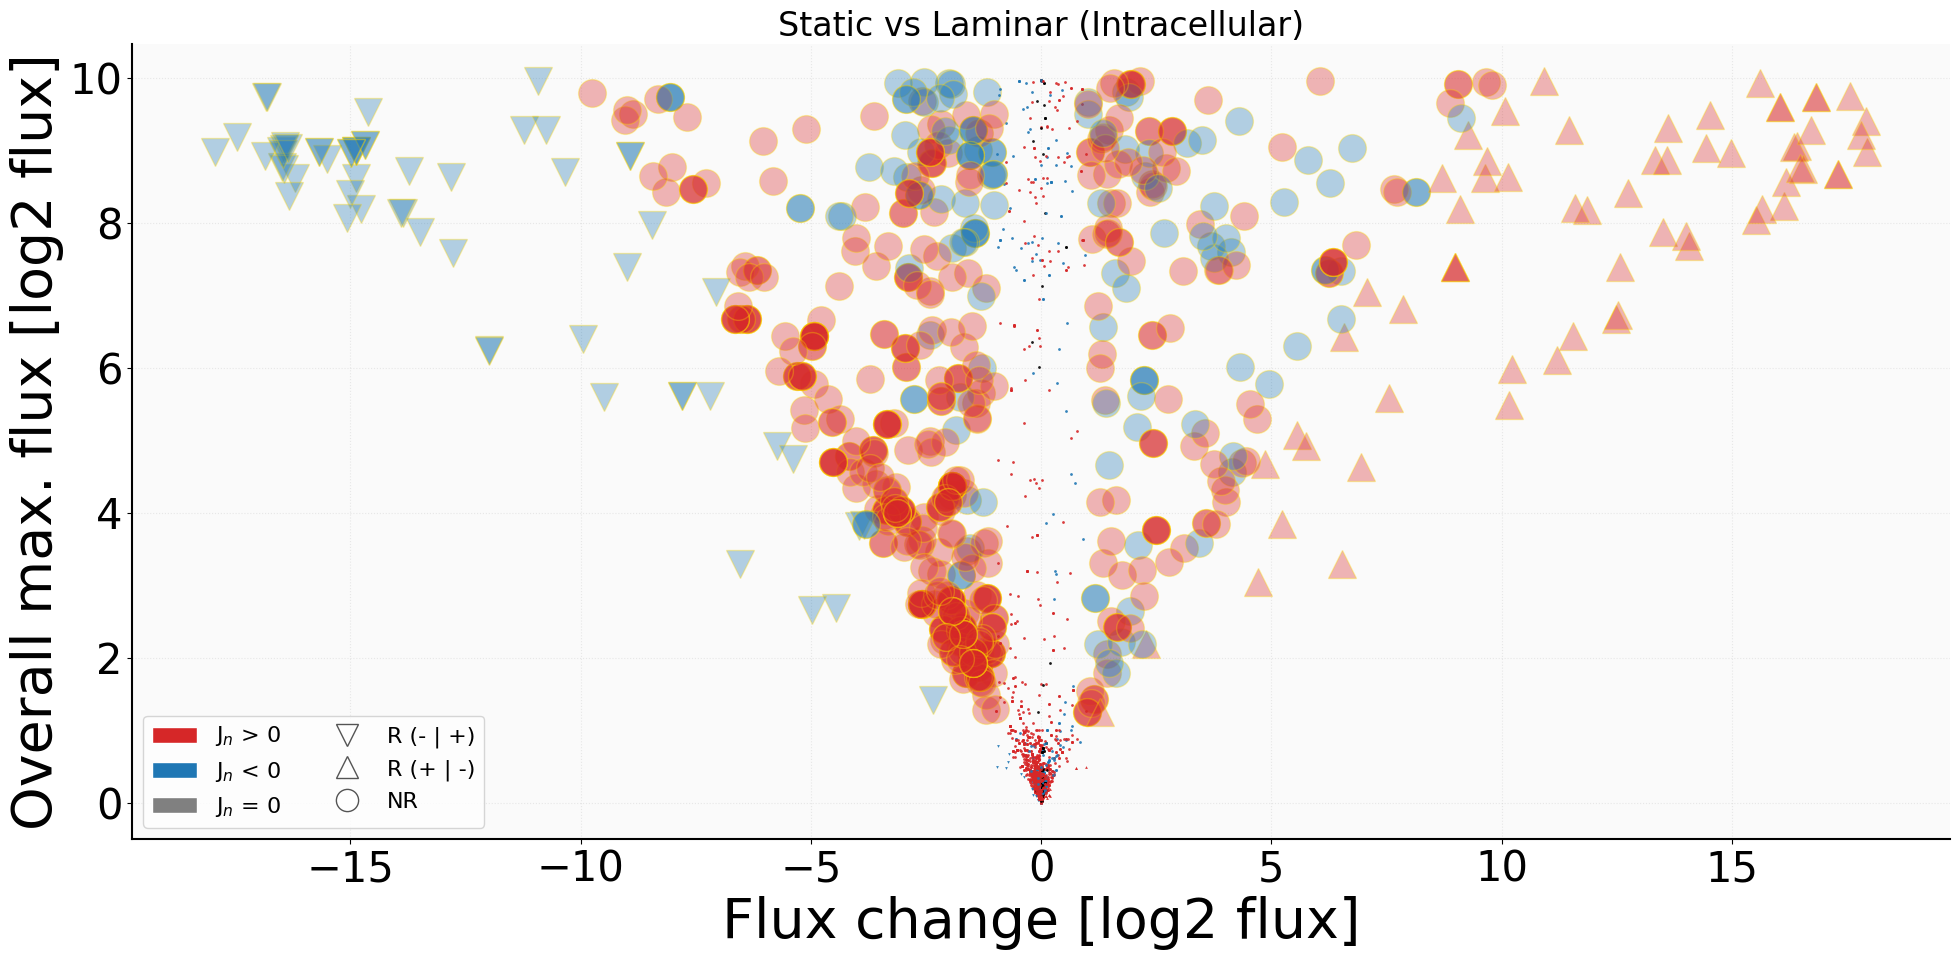

In [32]:
intracellular_conditions = flow_conditions[flow_conditions['Extracellular/Intracellular'] == 'Intracellular']
plot_filtered_volcano_Static_vs_Laminar(intracellular_conditions, title_suffix=" (Intracellular)", filename=path+"Static_vs_Laminar_Intracellular.svg")


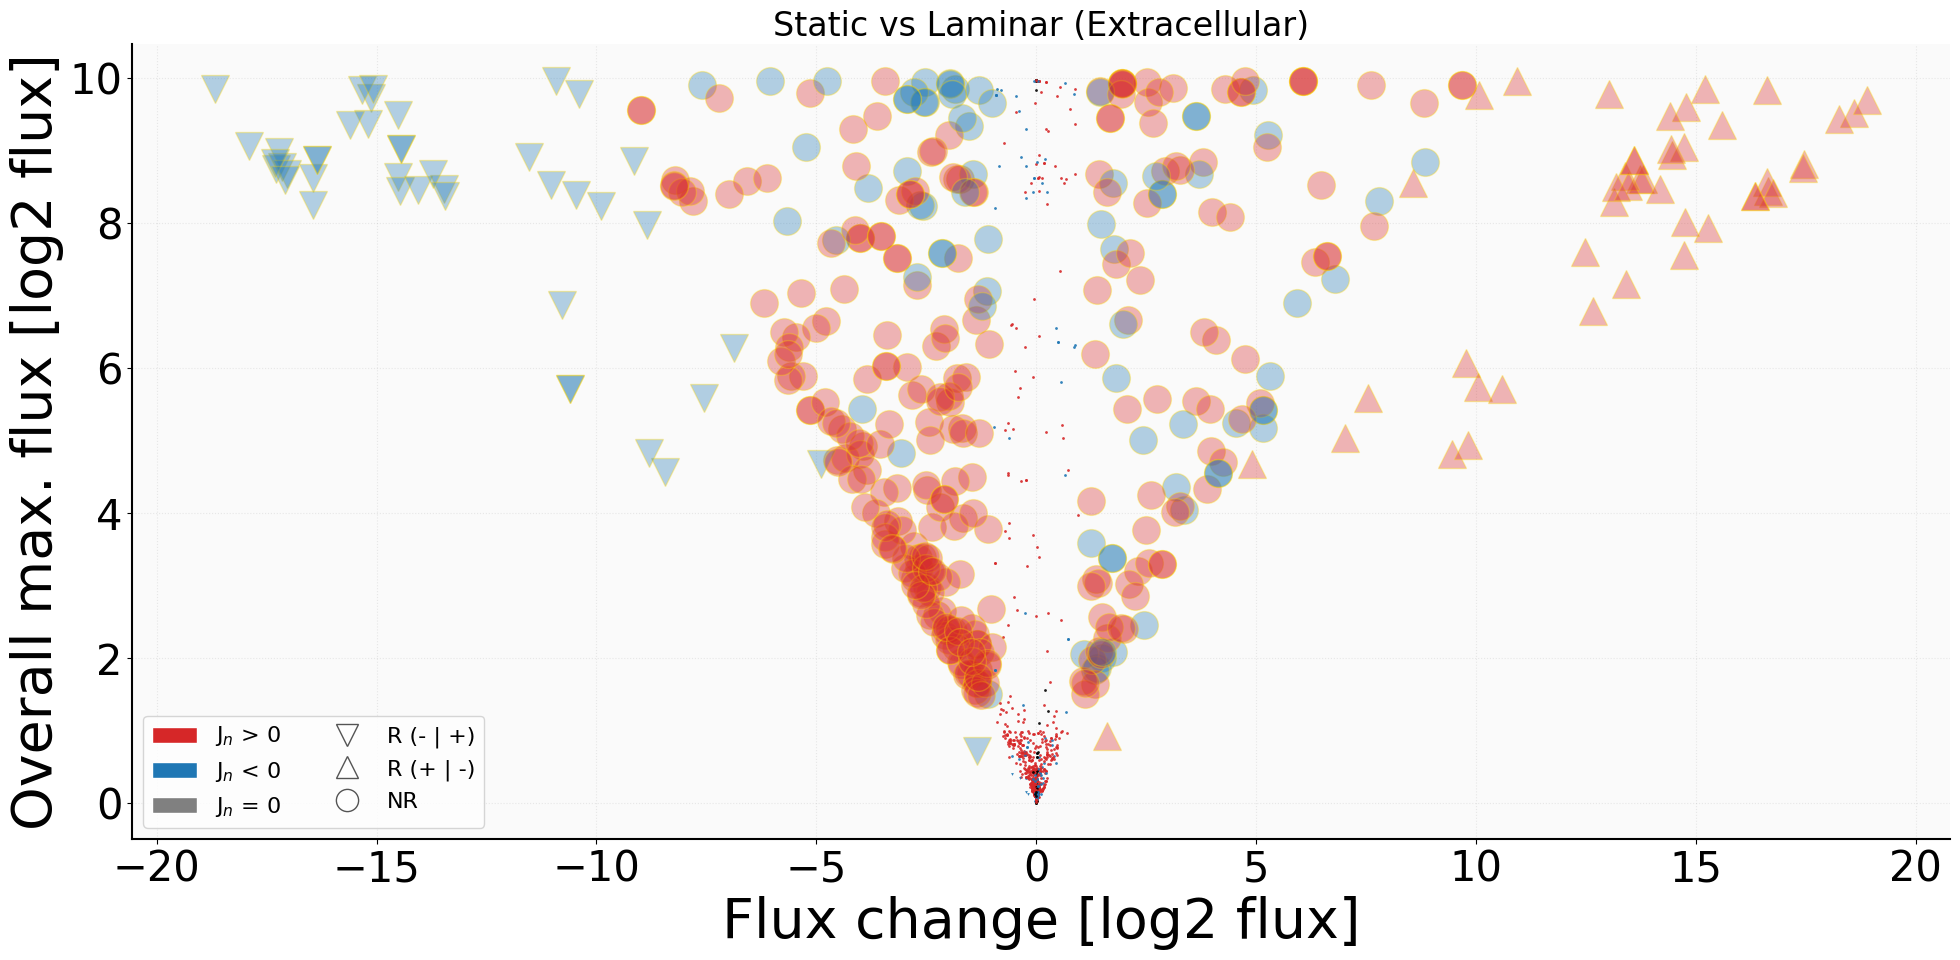

In [33]:
extracellular_conditions = flow_conditions[flow_conditions['Extracellular/Intracellular'] == 'Extracellular']
plot_filtered_volcano_Static_vs_Laminar(extracellular_conditions, title_suffix=" (Extracellular)", filename=path+"Static_vs_Laminar_Extracellular.svg")

In [39]:
def filtered_table_Static_vs_Laminar_updated_by_category(flow_conditions, category):
    # Filter only the rows that passed the significance test and have the given category
    filtered_data = flow_conditions[
        (flow_conditions["LaminarvsStatic_pval_pass"] == True) & 
        ((flow_conditions["LamvsStatic Median"] > 1) | (flow_conditions["LamvsStatic Median"] < -1)) &
        (flow_conditions["Extracellular/Intracellular"] == category)
    ]
    
    # Retrieve the relevant data columns
    static_90_median_values = filtered_data["Static_90_median"]
    laminar_90_median_values = filtered_data["Laminar_90_median"]
    corrected_pvalue = filtered_data["LaminarvsStatic_pval_corrected"]
    max_flux_1 = filtered_data["Laminar_90_median"]
    max_flux_2 = filtered_data["Static_90_median"]
    flux_difference = filtered_data["LamvsStatic Median"]
    max_flux_combined = max_flux_1.combine(max_flux_2, func=lambda x, y: max(abs(x), abs(y)))
    
    # Define the "Reverse" column based on flow direction
    reverse_column = []
    for i in range(len(max_flux_1)):
        if max_flux_1.iloc[i] > 0 and max_flux_2.iloc[i] < 0:
            reverse_column.append('R (- | +)')
        elif max_flux_1.iloc[i] < 0 and max_flux_2.iloc[i] > 0:
            reverse_column.append('R (+ | -)')
        else:
            reverse_column.append('')

    # Fetch the second level of the index
    subsystems = filtered_data.index.get_level_values(1)

    # Constructing the final dataframe
    final_df = pandas.DataFrame({
        'Static Flow': static_90_median_values,
        'Corrected pval. (BH)': corrected_pvalue,
        'Flux change [log2 flux]': flux_difference,
        'Overall max. flux [log2 flux]': max_flux_combined,
        'Laminar Flow (Reference)': laminar_90_median_values,
        'Flux Reversal': reverse_column,
        'Pathway': subsystems
    })
    
    # Setting the passed fluxes as index for the dataframe
    final_df.index = filtered_data.index.get_level_values(0)

    # Sorting the dataframe by the corrected p-value column in ascending order
    final_df = final_df.sort_values(by="Corrected pval. (BH)")

    return final_df

# For Extracellular
result_table_extracellular = filtered_table_Static_vs_Laminar_updated_by_category(flow_conditions, 'Extracellular')
display(Markdown("### Filtered Static Flow Vs Laminar Flow (Extracellular)"))
display(result_table_extracellular)

# For Intracellular
result_table_intracellular = filtered_table_Static_vs_Laminar_updated_by_category(flow_conditions, 'Intracellular')
display(Markdown("### Filtered Static Flow Vs Laminar Flow (Intracellular)"))
display(result_table_intracellular)


### Filtered Static Flow Vs Laminar Flow (Extracellular)

,Static Flow,Corrected pval. (BH),Flux change [log2 flux],Overall max. flux [log2 flux],Laminar Flow (Reference),Flux Reversal,Pathway
Flux IDs,,,,,,,
2HBt2,1.964631,0.000000e+00,7.551119,5.586488,-5.586488,R (+ | -),"Transport, extracellular"
r1747,1.994704,0.000000e+00,-6.586240,8.580944,8.580944,,"Transport, extracellular"
r1748,1.418022,0.000000e+00,-6.984754,8.402777,8.402777,,"Transport, extracellular"
r1755,8.528320,0.000000e+00,6.464453,8.528320,2.063867,,"Transport, extracellular"
r1757,0.372002,0.000000e+00,-3.634256,4.006258,4.006258,,"Transport, extracellular"
...,...,...,...,...,...,...,...
r1619,-6.863912,1.858860e-17,-10.778833,6.863912,3.914921,R (- | +),"Transport, extracellular"
r1649,-9.656670,3.340366e-15,-1.003035,9.656670,-8.653635,,"Transport, extracellular"
r1566,3.700820,3.329046e-07,9.765278,6.064458,-6.064458,R (+ | -),"Transport, extracellular"


### Filtered Static Flow Vs Laminar Flow (Intracellular)

,Static Flow,Corrected pval. (BH),Flux change [log2 flux],Overall max. flux [log2 flux],Laminar Flow (Reference),Flux Reversal,Pathway
Flux IDs,,,,,,,
2HBO,1.964631,0.000000e+00,7.551119,5.586488,-5.586488,R (+ | -),Propanoate metabolism
r0917,7.473766,0.000000e+00,15.519489,8.045723,-8.045723,R (+ | -),"Transport, mitochondrial"
r0795,9.920232,0.000000e+00,9.049224,9.920232,0.871008,,Miscellaneous
r0731,4.351668,0.000000e+00,-2.897548,7.249216,7.249216,,Fatty acid oxidation
r0730,4.351668,0.000000e+00,-2.897548,7.249216,7.249216,,Fatty acid oxidation
...,...,...,...,...,...,...,...
UMPK3n,-8.249673,3.512774e-08,-1.021796,8.249673,-7.227877,,Nucleotide interconversion
CYTK6,-5.144721,8.761183e-05,-1.842913,5.144721,-3.301808,,Nucleotide interconversion
AKGMALtm,-5.224383,4.032825e-03,1.344242,6.568625,-6.568625,,"Transport, mitochondrial"


In [35]:
def plot_filtered_volcano_Oscillatory_vs_Laminar(flow_conditions, title_suffix="", filename=None):
    difference = flow_conditions["LamvsOsci Median"]
    max_flux_1 = flow_conditions["Laminar_90_median"]
    max_flux_2 = flow_conditions["Oscillatory_90_median"]
    significance = flow_conditions["LaminarvsOscillatory_pval_pass"]
    valid_indices = (difference > 1) | (difference < -1)
    title = "Oscillatory vs Laminar" + title_suffix

    max_flux_combined = max_flux_1.combine(max_flux_2, func=lambda x, y: max(abs(x), abs(y)))

    for i in range(len(difference)):
        # Marker determination
        if (max_flux_1[i] > 0) & (max_flux_2[i] < 0):
            the_marker = 'v'
        elif (max_flux_1[i] < 0) & (max_flux_2[i] > 0):
            the_marker = '^'
        else:
            the_marker = 'o'
        
        # Color determination
        if max_flux_1[i] > 0 and max_flux_2[i] > 0 and difference[i] < 0:
            the_color = 'tab:red'
        elif max_flux_1[i] < 0 and max_flux_2[i] < 0 and difference[i] > 0:
            the_color = 'tab:blue'
        elif significance[i]:
            the_color = 'tab:red' if difference[i] > 0 else 'tab:blue'
        else:
            the_color = 'black'
        
        # Determine the size and opacity based on the filtering condition
        marker_size = 20 if valid_indices[i] else 2
        marker_alpha = 1/3 if valid_indices[i] else 0.9

        flux_name = flow_conditions.index.get_level_values('Flux IDs')[i]
        matplotlib.pyplot.plot(difference[i], max_flux_combined[i], color=the_color, alpha=marker_alpha, ms=marker_size, mec='None', marker=the_marker)

        # Only annotate with flux names for significant points
        #if valid_indices[i] and difference[i] != 0:
            #matplotlib.pyplot.text(difference[i], max_flux_combined[i], flux_name, fontsize=9, horizontalalignment='center', verticalalignment='center')

    # Legend
    legend_elements = [
        matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white'),
        matplotlib.patches.Patch(facecolor='tab:blue', edgecolor='white'),
        matplotlib.patches.Patch(facecolor='0.5', edgecolor='white'),
        matplotlib.lines.Line2D([0], [0], marker='v', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
        matplotlib.lines.Line2D([0], [0], marker='^', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
        matplotlib.lines.Line2D([0], [0], marker='o', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0)
    ]
    matplotlib.pyplot.legend(legend_elements, ['J$_n$ > 0', 'J$_n$ < 0', 'J$_n$ = 0', 'R (- | +)', 'R (+ | -)', 'NR'], ncol=2, fontsize=16, loc=3)

    ax = matplotlib.pyplot.gca()
    ax.set_facecolor("#FAFAFA")  # Light gray background color
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    matplotlib.pyplot.xlabel('Flux change [log2 flux]')
    matplotlib.pyplot.ylabel('Overall max. flux [log2 flux]')
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.tight_layout()
    if filename:
        matplotlib.pyplot.savefig(filename, format='svg')
    else:
        matplotlib.pyplot.show()

path = "/Users/jaydee/Desktop/Thesis Project/"


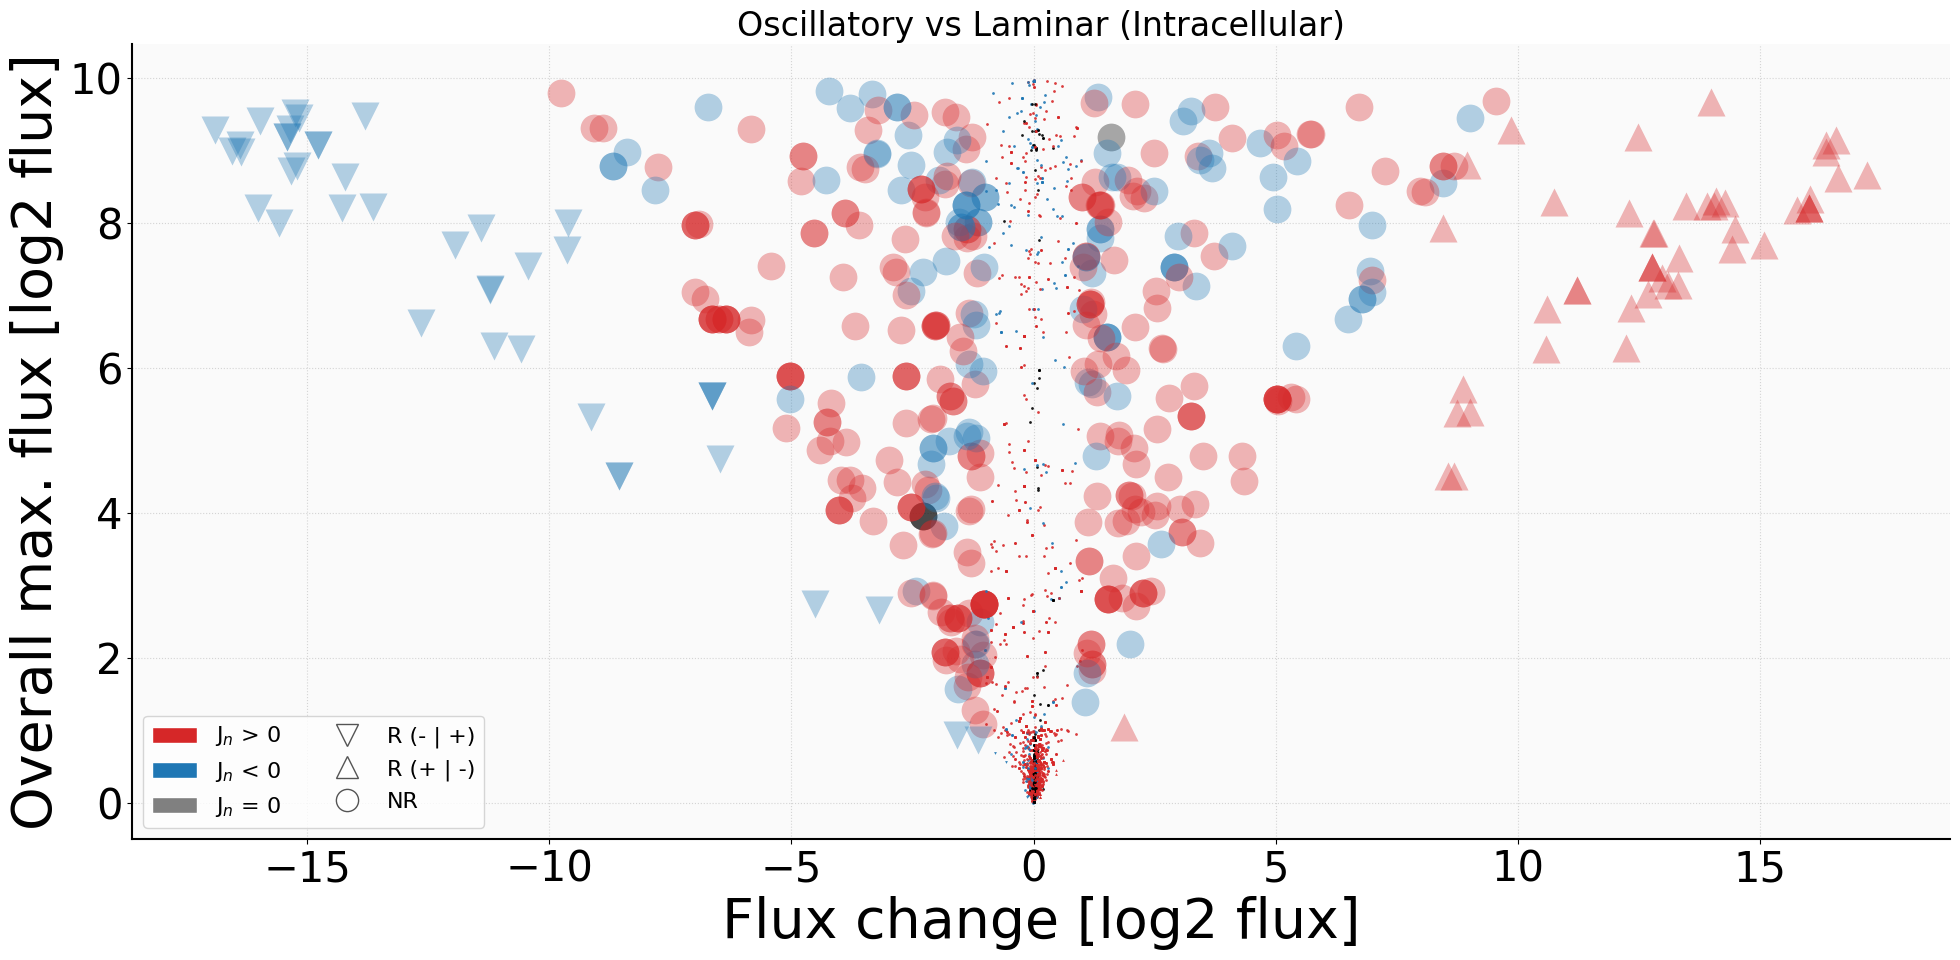

In [36]:
intracellular_conditions = flow_conditions[flow_conditions['Extracellular/Intracellular'] == 'Intracellular']
plot_filtered_volcano_Oscillatory_vs_Laminar(intracellular_conditions, title_suffix=" (Intracellular)", filename=path+"Oscillatory_vs_Laminar_Intracellular.svg")


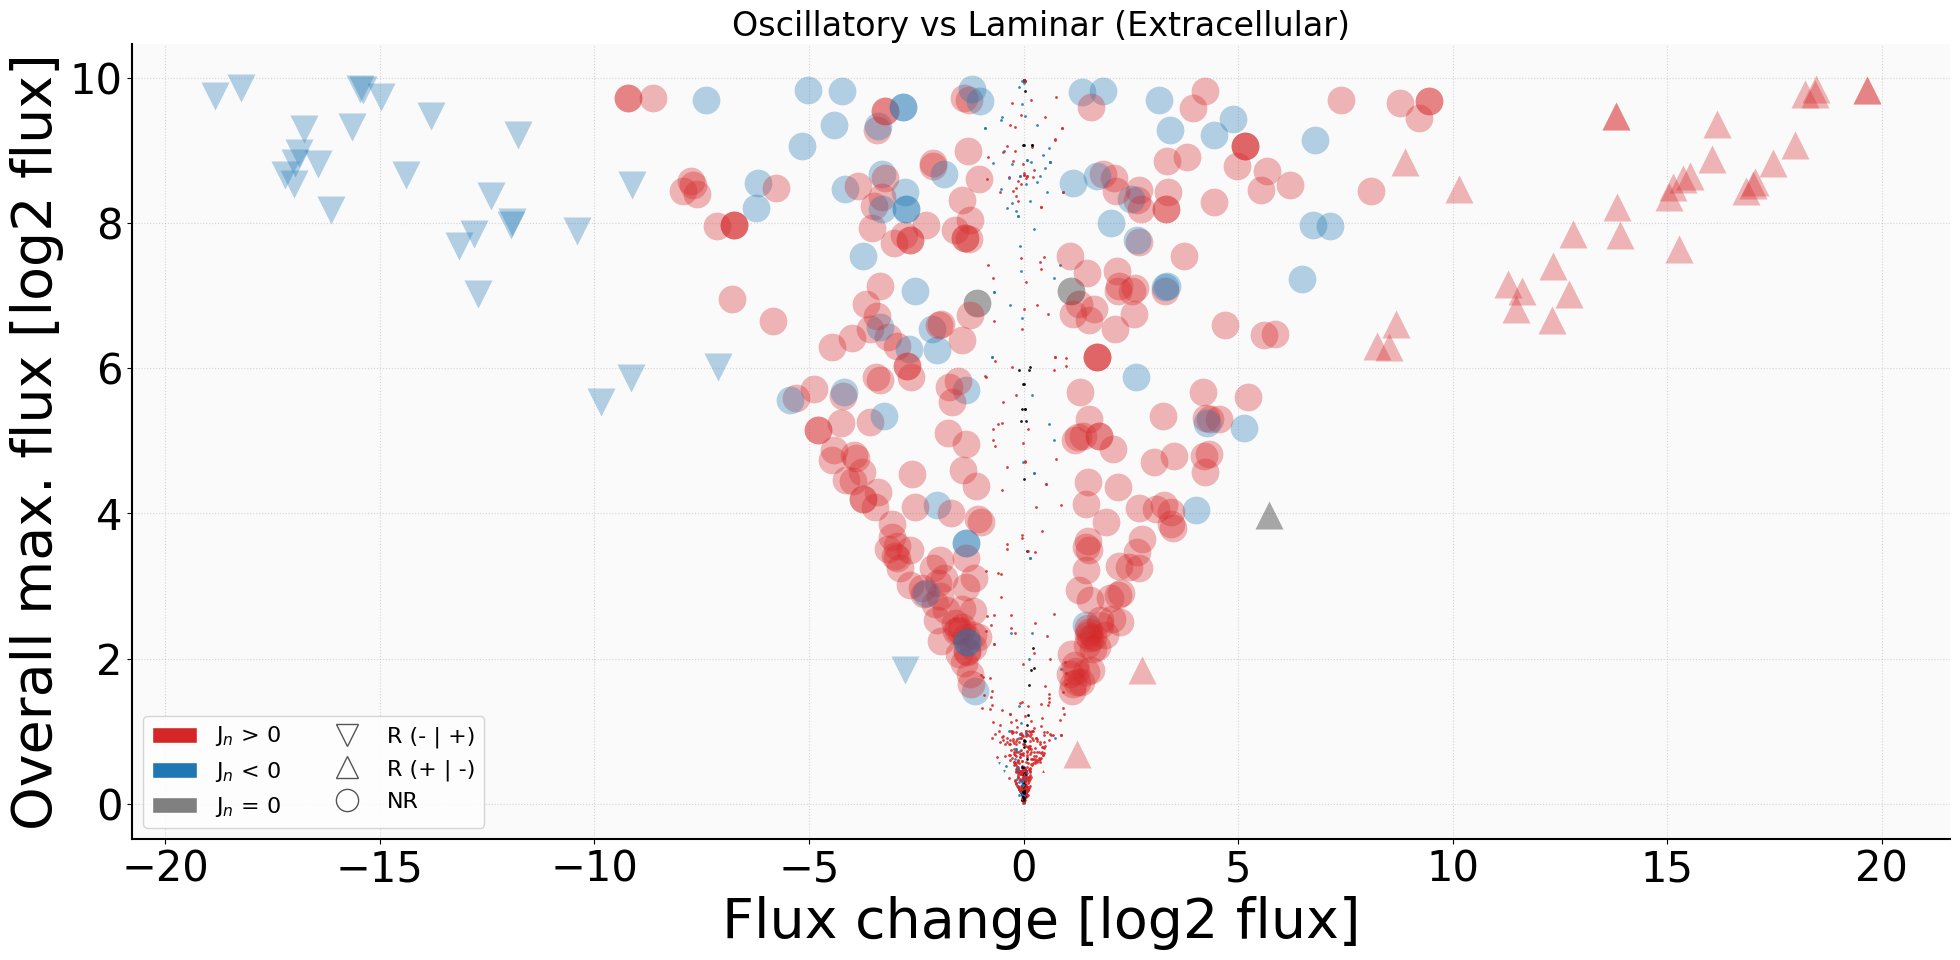

In [37]:
extracellular_conditions = flow_conditions[flow_conditions['Extracellular/Intracellular'] == 'Extracellular']
plot_filtered_volcano_Oscillatory_vs_Laminar(extracellular_conditions, title_suffix=" (Extracellular)", filename=path+"Oscillatory_vs_Laminar_Extracellular.svg")


In [40]:
def filtered_table_Oscillatory_vs_Laminar_updated_by_category(flow_conditions, category):
    # Filter only the rows that passed the significance test and have the given category
    filtered_data = flow_conditions[
        (flow_conditions["LaminarvsOscillatory_pval_pass"] == True) & 
        ((flow_conditions["LamvsOsci Median"] > 1) | (flow_conditions["LamvsOsci Median"] < -1)) &
        (flow_conditions["Extracellular/Intracellular"] == category)
    ]
    
    # Retrieve the relevant data columns
    oscillatory_90_median_values = filtered_data["Oscillatory_90_median"]
    laminar_90_median_values = filtered_data["Laminar_90_median"]
    corrected_pvalue = filtered_data["LaminarvsOscillatory_pval_corrected"]
    max_flux_1 = filtered_data["Laminar_90_median"]
    max_flux_2 = filtered_data["Oscillatory_90_median"]
    flux_difference = filtered_data["LamvsOsci Median"]
    max_flux_combined = max_flux_1.combine(max_flux_2, func=lambda x, y: max(abs(x), abs(y)))
    
    # Define the "Reverse" column based on flow direction
    reverse_column = []
    for i in range(len(max_flux_1)):
        if max_flux_1.iloc[i] > 0 and max_flux_2.iloc[i] < 0:
            reverse_column.append('R (- | +)')
        elif max_flux_1.iloc[i] < 0 and max_flux_2.iloc[i] > 0:
            reverse_column.append('R (+ | -)')
        else:
            reverse_column.append('')

    # Fetch the second level of the index
    subsystems = filtered_data.index.get_level_values(1)

    # Constructing the final dataframe
    final_df = pandas.DataFrame({
        'Laminar Flow': oscillatory_90_median_values,
        'Corrected pval. (BH)': corrected_pvalue,
        'Flux change [log2 flux]': flux_difference,
        'Overall max. flux [log2 flux]': max_flux_combined,
        'Laminar Flow (Reference)': laminar_90_median_values,
        'Flux Reversal': reverse_column,
        'Pathway': subsystems
    })
    
    # Setting the passed fluxes as index for the dataframe
    final_df.index = filtered_data.index.get_level_values(0)
    
    # Sorting the dataframe by the corrected p-value column in ascending order
    final_df = final_df.sort_values(by="Corrected pval. (BH)")
    
    return final_df

# For Extracellular
result_table_extracellular = filtered_table_Oscillatory_vs_Laminar_updated_by_category(flow_conditions, 'Extracellular')
display(Markdown("### Filtered Oscillatory Flow Vs Laminar Flow (Extracellular)"))
display(result_table_extracellular)

# For Intracellular
result_table_intracellular = filtered_table_Oscillatory_vs_Laminar_updated_by_category(flow_conditions, 'Intracellular')
display(Markdown("### Filtered Oscillatory Flow Vs Laminar Flow (Intracellular)"))
display(result_table_intracellular)


### Filtered Oscillatory Flow Vs Laminar Flow (Extracellular)

,Laminar Flow,Corrected pval. (BH),Flux change [log2 flux],Overall max. flux [log2 flux],Laminar Flow (Reference),Flux Reversal,Pathway
Flux IDs,,,,,,,
2HBt2,-9.820525,0.000000,-4.234037,9.820525,-5.586488,,"Transport, extracellular"
r1940,4.659709,0.000000,-3.854585,8.514294,8.514294,,"Transport, extracellular"
r1937,1.089649,0.000000,-8.633017,9.722666,9.722666,,"Transport, extracellular"
r1925,0.423763,0.000000,-2.987844,3.411607,3.411607,,"Transport, extracellular"
r1922,0.319077,0.000000,-4.144844,4.463921,4.463921,,"Transport, extracellular"
...,...,...,...,...,...,...,...
r1570,-6.256885,0.001649,-2.019908,6.256885,-4.236977,,"Transport, extracellular"
r1658,6.812210,0.004092,1.651483,6.812210,5.160727,,"Transport, extracellular"
r1660,6.666445,0.008661,1.523104,6.666445,5.143341,,"Transport, extracellular"


### Filtered Oscillatory Flow Vs Laminar Flow (Intracellular)

,Laminar Flow,Corrected pval. (BH),Flux change [log2 flux],Overall max. flux [log2 flux],Laminar Flow (Reference),Flux Reversal,Pathway
Flux IDs,,,,,,,
2HBO,-9.820525,0.000000,-4.234037,9.820525,-5.586488,,Propanoate metabolism
HMGLm,7.209868,0.000000,6.995844,7.209868,0.214024,,Cholesterol metabolism
HPDCACRNt,-9.188583,0.000000,-15.429577,9.188583,6.240994,R (- | +),Fatty acid oxidation
ILEt5m,0.849885,0.000000,-5.040793,5.890679,5.890679,,"Transport, mitochondrial"
ILETAm,0.849885,0.000000,-5.040793,5.890679,5.890679,,"Valine, leucine, and isoleucine metabolism"
...,...,...,...,...,...,...,...
r0617,7.387524,0.008069,1.030167,7.387524,6.357357,,Arginine and proline metabolism
TETTET6CPT2,-4.910032,0.023739,1.509788,6.419820,-6.419820,,Fatty acid oxidation
TETTET6CPT1,-4.910032,0.023739,1.509788,6.419820,-6.419820,,Fatty acid oxidation


In [41]:
# For Extracellular
result_table_extracellular = filtered_table_Static_vs_Laminar_updated_by_category(flow_conditions, 'Extracellular')
result_table_extracellular.to_excel(path+"Filtered_Static_vs_Laminar_Extracellular.xlsx")

# For Intracellular
result_table_intracellular = filtered_table_Static_vs_Laminar_updated_by_category(flow_conditions, 'Intracellular')
result_table_intracellular.to_excel(path+"Filtered_Static_vs_Laminar_Intracellular.xlsx")

# For Extracellular
result_table_extracellular = filtered_table_Oscillatory_vs_Laminar_updated_by_category(flow_conditions, 'Extracellular')
result_table_extracellular.to_excel(path+"Filtered_Oscillatory_vs_Laminar_Extracellular.xlsx")

# For Intracellular
result_table_intracellular = filtered_table_Oscillatory_vs_Laminar_updated_by_category(flow_conditions, 'Intracellular')
result_table_intracellular.to_excel(path+"Filtered_Oscillatory_vs_Laminar_Intracellular.xlsx")

#flow_conditions.to_excel(path+"flow_conditions.xlsx")